In [1]:
#import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import pygmt #to plot things
import xrft

#fatiando libraries
import harmonica as hm 
import verde as vd

from matplotlib import rcParams
rcParams["figure.dpi"] = 130 #make figures larger

In [2]:
data = pd.read_csv('landgrav_csv.csv')

/var/folders/8v/mbt7tvjn7wgf9c1zyghww_3c0000gn/T/ipykernel_28173/1081655705.py:1: DtypeWarning: Columns (8,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('landgrav_csv.csv')


In [3]:
en = ([152207.0, 173499.0], [725285.0, 738732.0])

#adding 
extend = 30e3 #value to extend eastings and northings by, in metres

# Values to add to each number
additions = [[-extend, extend], [-extend, extend]] # what to add to each value

# Extending the region
updated_en = tuple(
    [en[i][j] + additions[i][j] for j in range(len(en[i]))] for i in range(len(en))
)

w_original = en[0][0]
e_original = en[0][1]
s_original = en[1][0]
n_original = en[1][1]
# storing the original easting northing limits (in metres)

eastings_d, northings_d = updated_en # storing updated easting northing limits, in metres

region_deg_ext = (eastings_d,northings_d)

region_deg = region_deg_ext[0] + region_deg_ext[1] # creating a new variable which is usable to define a region with Verde

region_deg_of_interest = en[0] + en[1]

inside = vd.inside((data.GRID_EAST,data.GRID_NORTH),
                   region_deg) # defining a filter with Verde

inside_of_interest = vd.inside((data.GRID_EAST,data.GRID_NORTH),
                   region_deg_of_interest)

In [4]:
DataZoom = data[inside]
Data_of_interest = data[inside_of_interest]

lat = DataZoom["GRID_NORTH"].astype('float')
long = DataZoom["GRID_EAST"].astype('float')
elev = DataZoom["STATION_ELEV"].astype('float')

Bouguer_Anomaly = DataZoom.BOUGUER_AN

lat_interest = Data_of_interest["GRID_NORTH"].astype('float') # northing
long_interest = Data_of_interest["GRID_EAST"].astype('float') # easting
elev_interest = Data_of_interest["STATION_ELEV"].astype('float') # elevation of data

Bouguer_Anomaly_interest = Data_of_interest.BOUGUER_AN # Bouguer anomaly

region = vd.get_region((eastings_d, northings_d))

region_of_interest = vd.get_region(en)

# DataZoom = DataZoom.assign(easting=easting)
# DataZoom = DataZoom.assign(northing=northing)

coordinates = (long,lat,elev)
coordinates_of_interest = (long_interest,lat_interest,elev_interest) # bringing coordinates together for use later

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


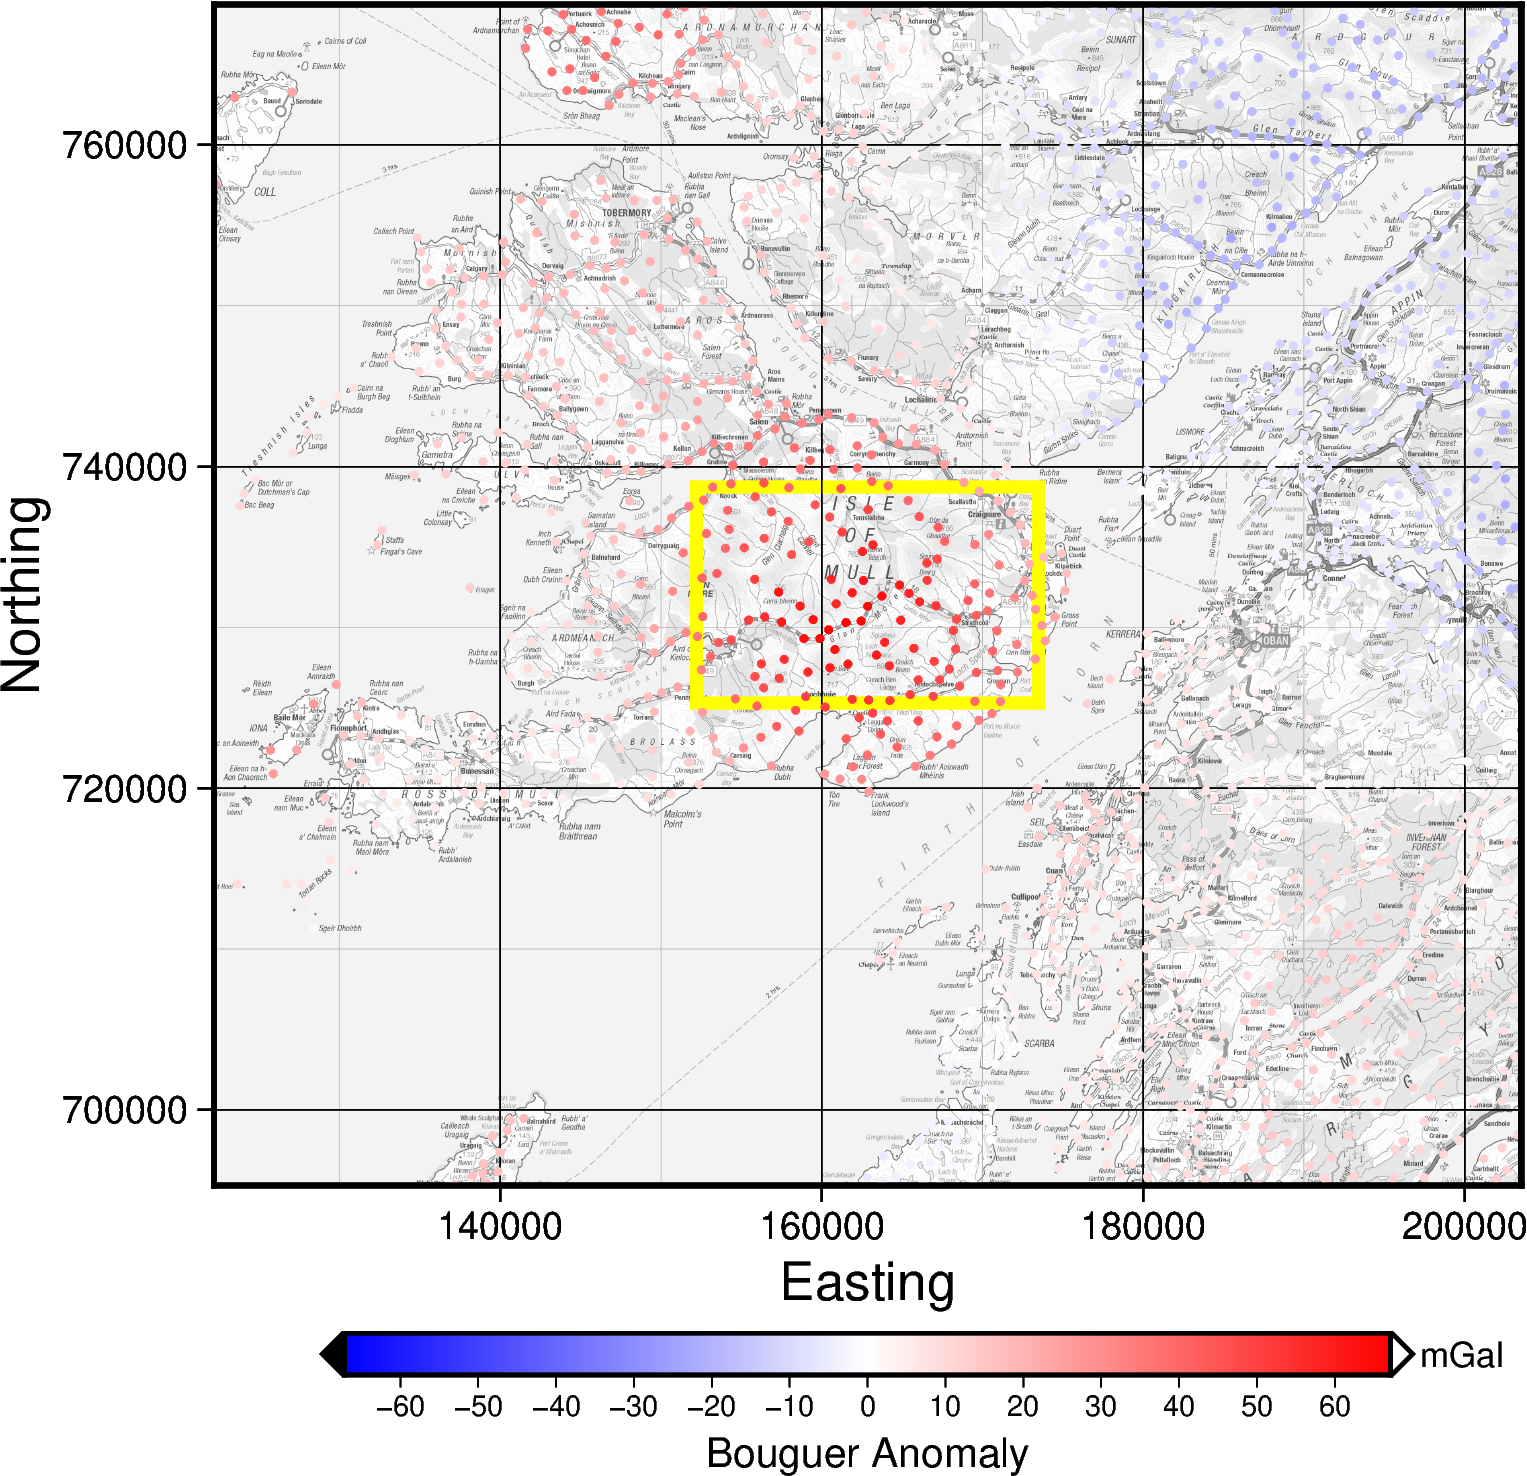

In [16]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"
maxabs = vd.maxabs(Bouguer_Anomaly)

fig = pygmt.Figure()

pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])

title=""#"Raw Bouguer Anomaly Data"
with pygmt.config(FONT_TITLE="14p"):

   fig.grdimage(
      grid = "Mull.tif",
      dpi = 300,
      region = region,
      frame=['ag', f"+t{title}"],
      projection=fig_proj,
      monochrome = True,
      transparency = 30
   )

   fig.plot(data=np.array([[e_original,s_original,w_original,n_original]]), style='r+s', pen="3p,yellow")
   
   fig.plot(
      x=long,
      y=lat,
      fill=Bouguer_Anomaly,
      cmap=True,
      style="c2p",
      projection=fig_proj,
      region=region,
      frame=['ag', f"+t{title}", "xaf+lEasting", "yaf+lNorthing"]
   )
   fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a10f10", "x+lBouguer Anomaly", "y+lmGal"])

fig.savefig("Bouguer_Anomaly_Data.pdf")
fig.show()

## Creating an Equivalent Layer

Equivalent layers require Cartesian coordinates to be generated, hence why easting northing coordinates have been used instead of latitude and longitude.

Here, block averaging is being used, since sampling is unevenly distributed across the area.

In [6]:
print('Number of data points: ',np.shape(coordinates)[1])

Number of data points:  1539


In [7]:
# block_size: should be smaller than desired resolution of grid (0.5km, as per Smith & Royles, 1987) 

eql = hm.EquivalentSources(damping=0.1, # can change (removes artifacts by smoothing coefficients of equivalent layer)
                           depth=5e3, # 5km depth
                           block_size = 400 # since the resolution is around 500m
                          )

eql.fit(coordinates, Bouguer_Anomaly)
print(eql.points_[0].size)

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x1151b5bc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x1151b5bc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


1535


### Check whether the equivalent layer can predict the true values

In [8]:
anomaly = eql.predict(coordinates)

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


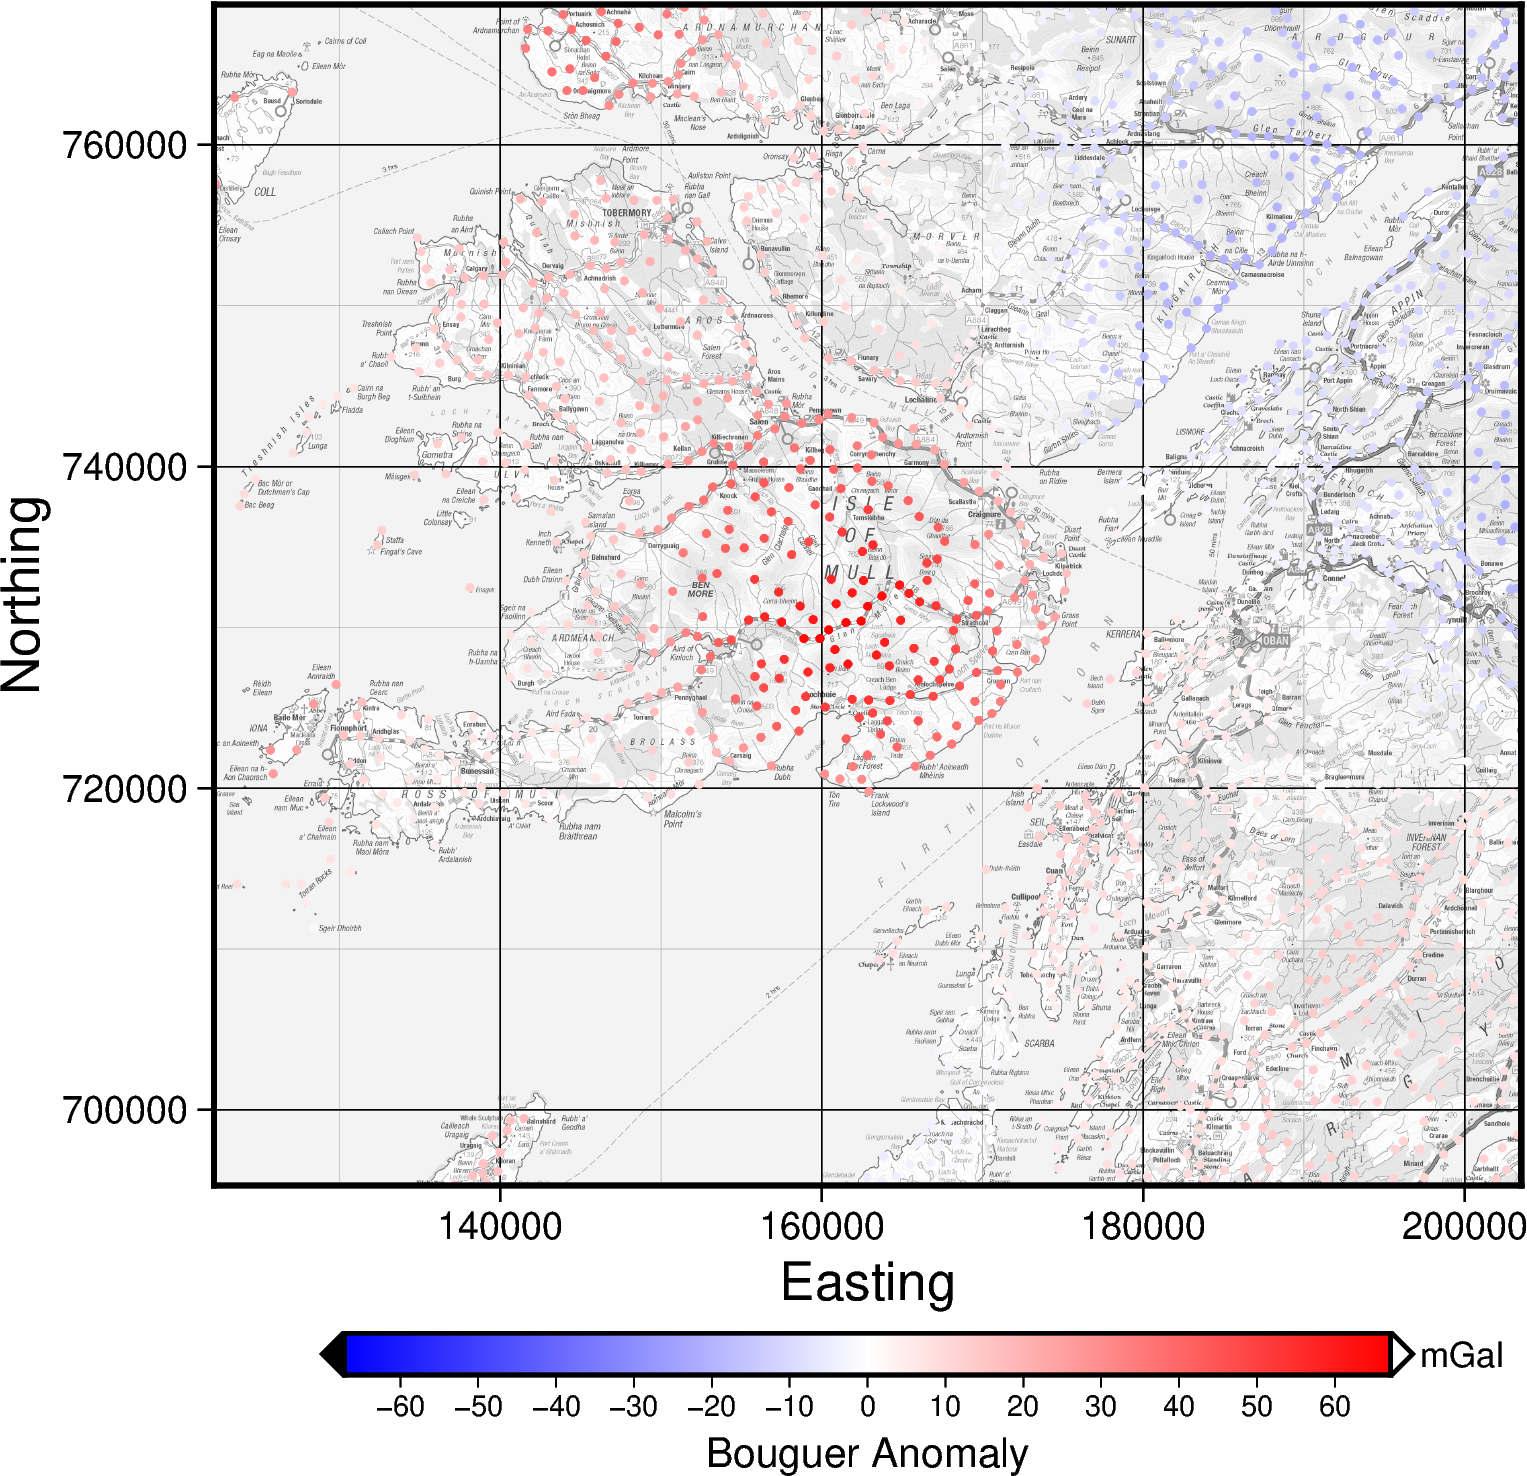

In [10]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

fig = pygmt.Figure()
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
with pygmt.config(FONT_TITLE="14p"):
      fig.grdimage(
            grid = "Mull.tif",
            dpi = 300,
            region = region,
            projection=fig_proj,
            monochrome = True,
            transparency = 30
         )

      fig.plot(
         x=long,
         y=lat,
         fill=anomaly,
         cmap=True,
         style="c2p",
         projection=fig_proj,
         region=region,
         transparency = 0,
         frame=["ag", "xaf+lEasting", "yaf+lNorthing"],
         )

      fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a10f10", "x+lBouguer Anomaly", "y+lmGal"])

fig.savefig("EQL_Test_Gravity.pdf")
fig.show()

## Find maximum observation height

In [11]:
print('Maximum height: ',elev.max(),'m') # printing the maximum elevation, giving an estimate for upward-continuing the data

Maximum height:  966.0 m


In [ ]:
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=500, # Resolution of 500m
    extra_coords=1.5e3, # Above the maximum height, meaning data are also upward-continued
)

grid = eql.grid(grid_coords, 
                data_names=["gravity_disturbance"],
                dim=("latitude","longitude")
                ) # gridding the data

/usr/local/Caskroom/miniforge/base/envs/hm/lib/python3.12/site-packages/harmonica/_equivalent_sources/cartesian.py:460: FutureWarning: The 'dim' arguments are being ignored. The 'grid' method will not take any keyword arguments in the next Harmonica release
  warnings.warn(


In [13]:
# Create a new DataArray, keeping the existing coordinates
grid_DataArray = xr.DataArray(
    data=grid['gravity_disturbance'].values,
    coords={
        'northing': grid['northing'],
        'easting': grid['easting'],
        'upward': grid['upward']  # Assuming 'upward' is part of the dataset
    },
    dims=['northing', 'easting']
)

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


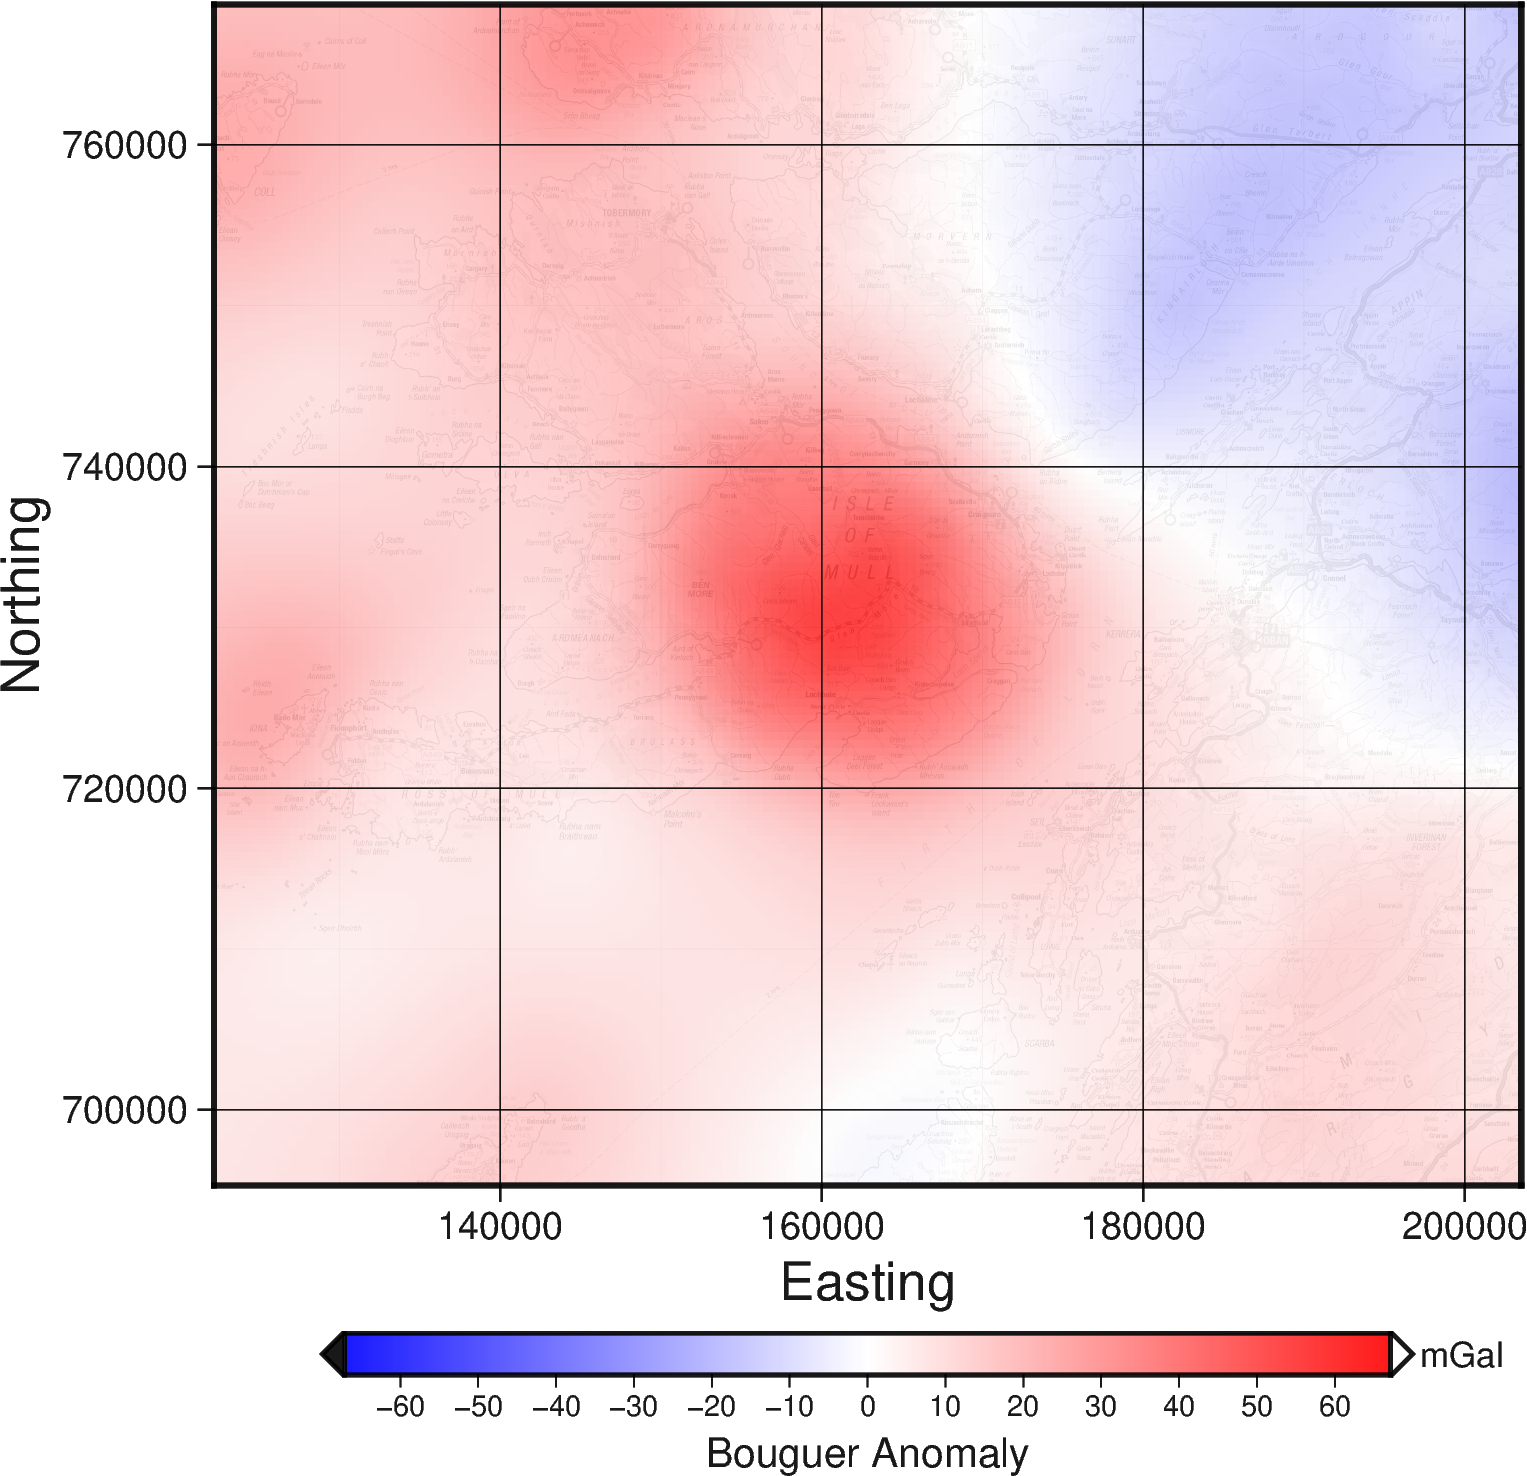

In [ ]:
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"
fig = pygmt.Figure()

pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
with pygmt.config(FONT_TITLE="14p"):
   fig.grdimage(
         grid = "Mull.tif",
         dpi = 300,
         region = region,
         projection=fig_proj,
         monochrome = True,
         transparency = 0
      )

   fig.grdimage(
      grid=grid.gravity_disturbance,
      cmap=True,
      transparency = 10,
      frame=["ag", "xaf+lEasting", "yaf+lNorthing"]
   )
   fig.colorbar(cmap=True, position="JBC+h+o0/1.25c+e", frame=["a10f10", "x+lBouguer Anomaly", "y+lmGal"],
                  transparency = 10)

fig.savefig("Check_Gridding_Grav.pdf")
fig.show()


# Taking a profile

### Convert Easting Northing to LonLat in EPSG:27700

In [18]:
eastings_profile = [143036.1648,169150.5467]
northings_profile = [757355.7188,719328.4365]

#filter out those parts of the profile outside the area of interest
def distance_to_a(x1, y1, x2, y2, ya):
    # Gradient
    m = (y2 - y1) / (x2 - x1)

    c = y1-m*x1

    xa = (ya-c)/m

    distance = np.sqrt((x1-xa)**2+(y1-ya)**2)/1e3 # converting to km

    return distance
start = ([eastings_profile[0],northings_profile[0]])
end = ([eastings_profile[1],northings_profile[1]])

print(n_original)
print(s_original)
end_profile = distance_to_a(eastings_profile[0], northings_profile[0], eastings_profile[1], northings_profile[1],s_original) #bottom region
print(end_profile)
start_profile = distance_to_a(eastings_profile[0], northings_profile[0], eastings_profile[1], northings_profile[1],n_original) #top region
print(start_profile)

738732.0
725285.0
38.904765577954045
22.592303547114017


In [19]:
profile = eql.profile(
	start,
	end,
	upward=elev.max(), #location of equivalent layer -> is this correct?
	size=200,
	data_names = ["bouguer_disturbance"],
	dims = ("latitude","longitude"), #correct from northing easting labels in dataframe
)

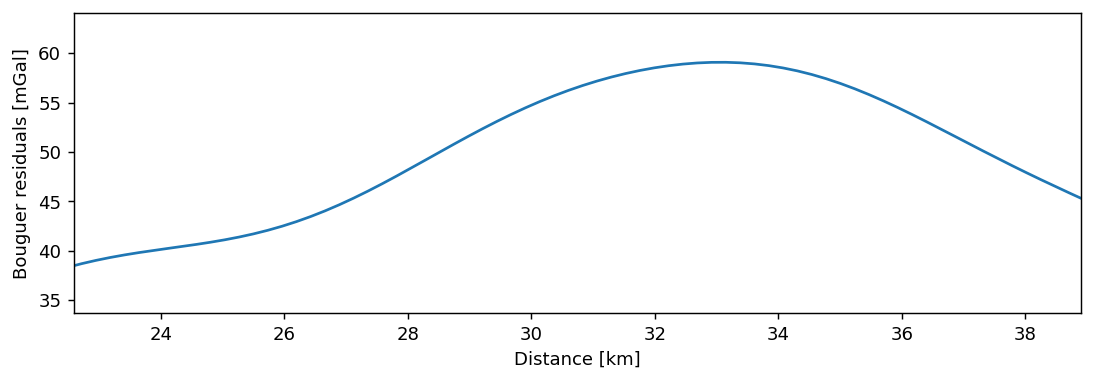

In [20]:
interest = (start_profile*1e3 < profile.distance) & (profile.distance < end_profile*1e3)
interest_disturbance = profile.bouguer_disturbance[interest]

fig,ax = plt.subplots()

ax.plot(profile.distance/1000,profile.bouguer_disturbance)

fig.set_size_inches(10,3)
ax.set_xlim(start_profile,end_profile)
ax.set_ylim(min(interest_disturbance)-5,max(interest_disturbance)+5)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Bouguer residuals [mGal]")
ax.annotate("A'", xy=(start_profile+0.25,25))
ax.annotate("A'", xy=(end_profile-0.5,25))
plt.show()

grdimage [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: w reset from 122207 to 122200
grdimage [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdimage [WARNING]: e reset from 203499 to 203500
grdimage [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: s reset from 695285 to 695275
grdimage [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdimage [WARNING]: n reset from 768732 to 768750


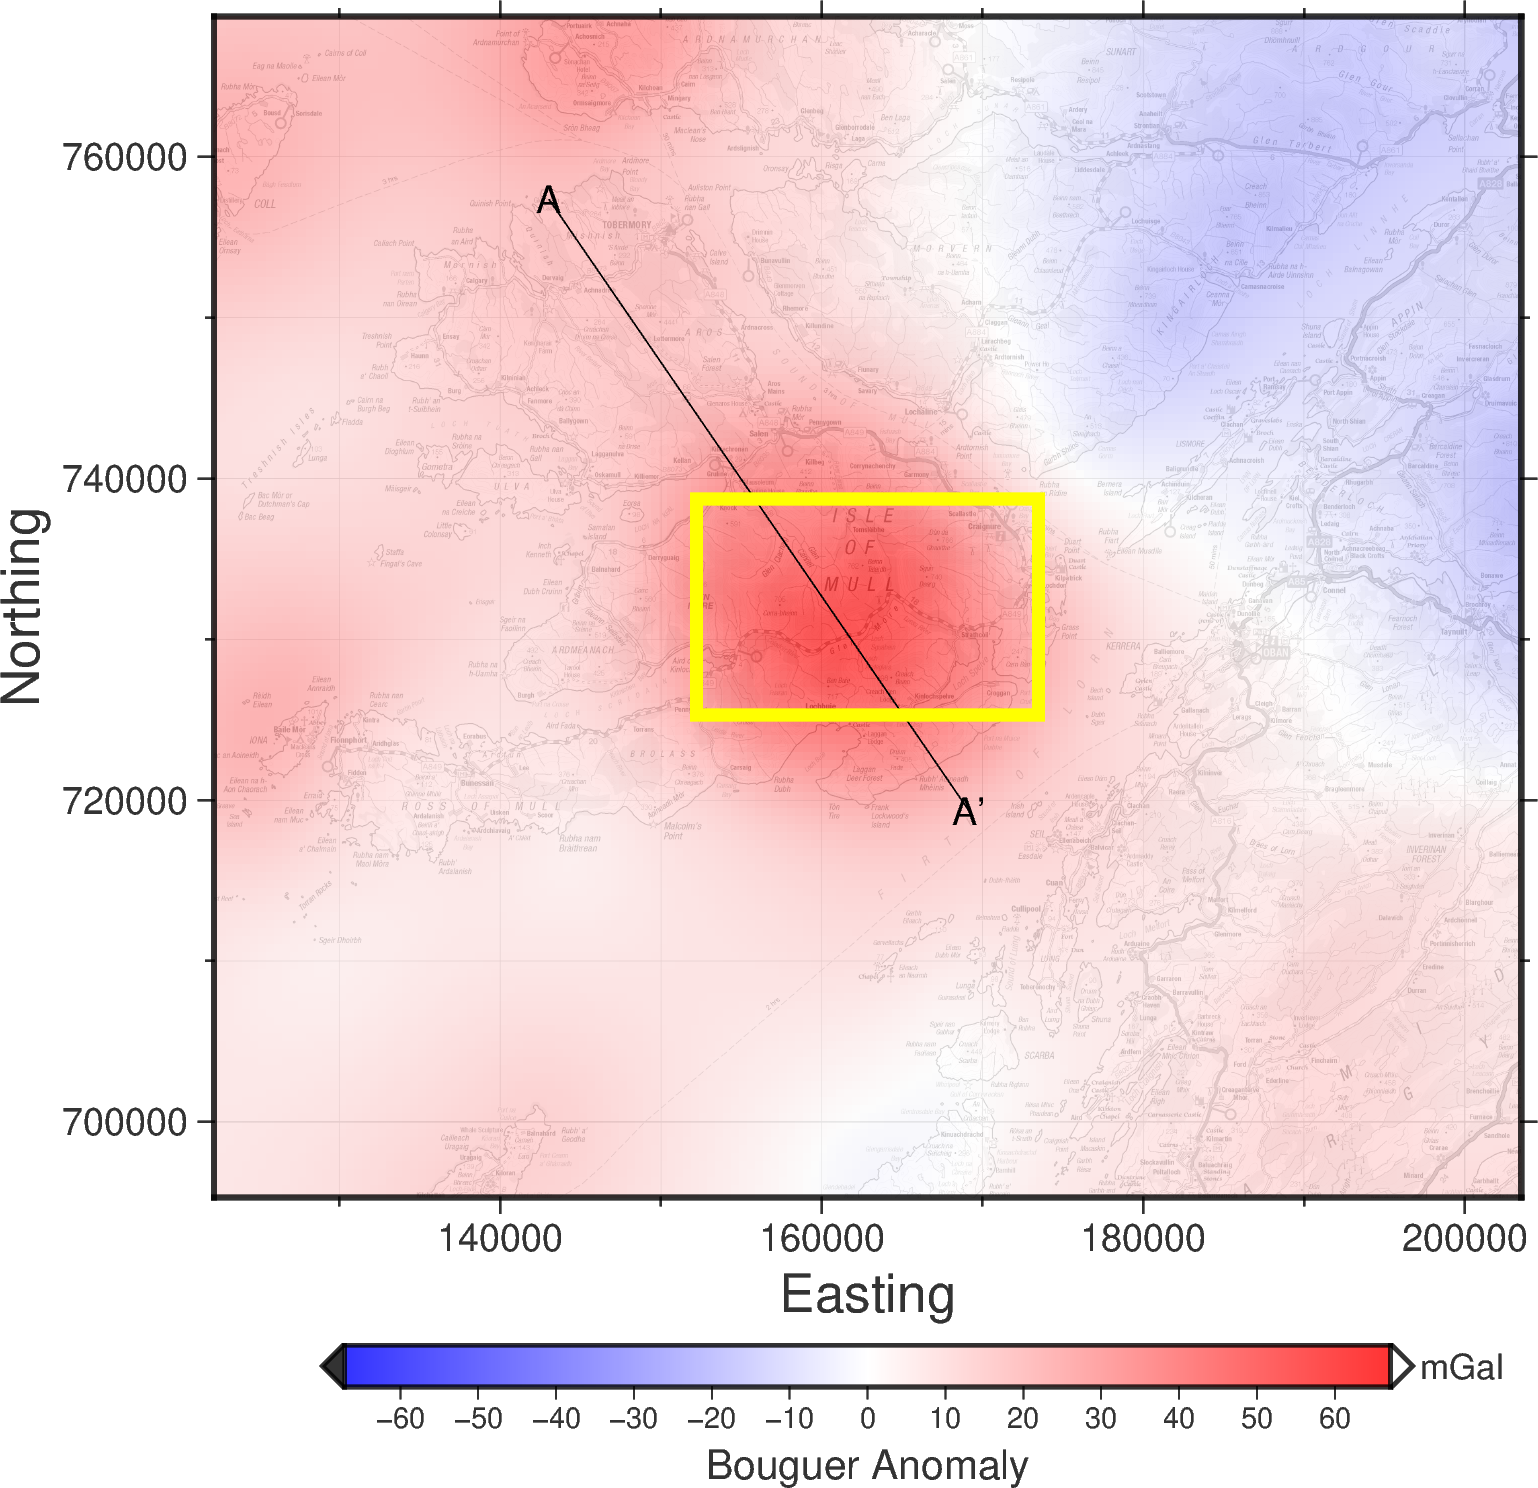

In [21]:
#####
fig = pygmt.Figure()

with pygmt.config(FONT_TITLE="14p"):
   
   pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])

   fig.grdimage(
      grid = "Mull.tif",
      dpi = 300,
      region = region_deg,
      projection=fig_proj,
      monochrome = True,
   )

   fig.grdimage(
      frame=['af', 'WSen', "xaf+lEasting", "yaf+lNorthing"],
      grid=grid.gravity_disturbance,
      region=region_deg,
      projection=fig_proj,
      cmap=True,
      nan_transparent=True,
      transparency = 20
      )
   fig.colorbar(cmap=True, 
                position="JBC+h+o0/1.25c+e",
                frame=["a10f10", "x+lBouguer Anomaly", "y+lmGal"],
                transparency = 20)

   x = [p[0] for p in (start, end)]
   y = [p[1] for p in (start, end)]
   fig.plot(x=x, y=y)
   fig.text(text=["A", "A'"], x=[start[0], end[0]], y=[start[1]-0.02, end[1]-0.02])

   fig.plot(data=np.array([[e_original,s_original,w_original,n_original]]), style='r+s', pen="3p,yellow")

fig.savefig("Bouguer_anomaly_w_cross-sec.pdf")
fig.show()

In [22]:
profile_array = np.column_stack((profile.distance.values,profile.bouguer_disturbance.values))

np.savetxt('grav_profile_array.txt',profile_array)